# Objetivo: Regressão no dataset “Real estate valuation” (UCI) com modelos do scikit-learn

    Reaproveitar suas funções utilitárias (aux.*) para métricas (incluindo Hit@10), correlações e análise de resíduos.

    Avaliar modelos adicionais além de Perceptron Logístico/MLP:
    SVR (linear/rbf), DecisionTreeRegressor, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, BaggingRegressor.

    Comparar 4 tratamentos de features: sem normalização, z-score, min-max e interquartil (IQR).

    Selecionar o melhor absoluto priorizando Hit@10 (depois Hit@20, R² e, por fim, RMSE menor).

    Manter k-fold e toda a impressão/análise via aux.imprimir_metricas, aux.imprimir_correlacoes e aux.analisar_residuos.


In [1]:
import numpy as np
import pandas as pd

from ucimlrepo import fetch_ucirepo
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Modelos sklearn
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, ExtraTreesRegressor,
    GradientBoostingRegressor, BaggingRegressor
)

# Pacote do trabalho (funções utilitárias)
from trabalho_ic_aplicada.models import aux

np.random.seed(42)


2025-08-10 20:26:31.413 | INFO     | trabalho_ic_aplicada.config:<module>:11 - PROJ_ROOT path is: /home/apo-pc/Documents/Github/Trabalhos_IC_Aplicada


### [01] Carregamento do dataset e definição dos folds

    Mesmo dataset e estrutura de folds do seu código, para comparabilidade.

    Não normalizamos o alvo y (a normalização aqui será apenas nas features).

In [2]:
real_estate_valuation = fetch_ucirepo(id=477)

# Nomes das variáveis (apenas informativo; a 1ª é data)
features = real_estate_valuation.variables.iloc[1:, 0].values

# Matriz X e vetor y
X = real_estate_valuation.data.features.to_numpy()
y = real_estate_valuation.data.targets.to_numpy().ravel()

# Remove a 1ª coluna (data de transação)
X = X[:, 1:]

# Índices dos folds (mesmo esquema do seu projeto)
k_fold = aux.validacao_cruzada_kfold(X, y, k=10)
len(k_fold)


10

### [02] Escalonadores de features e critério de seleção

    Escalonadores:

        "none" → sem normalização (pass-through)

        "zscore" → StandardScaler

        "minmax" → MinMaxScaler

        "iqr" → RobustScaler (faixa interquartil)

    Critério do “melhor absoluto”: ordenar por Hit@10 (desc), depois Hit@20 (desc), R² (desc) e RMSE (asc).

In [3]:

def make_scaler(kind: str):
    if kind == "none":
        return "passthrough"
    if kind == "zscore":
        return StandardScaler()
    if kind == "minmax":
        return MinMaxScaler()
    if kind == "iqr":
        # IQR ~ robust scaler
        return RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0))
    raise ValueError(f"Escalonador desconhecido: {kind}")


def rank_dataframe(df):
    # Ordena por: Hit@10 desc, Hit@20 desc, R2 desc, RMSE asc
    return df.sort_values(
        by=["Hit@10_mean", "Hit@20_mean", "R2_mean", "RMSE_mean"],
        ascending=[False, False, False, True]
    ).reset_index(drop=True)


### [03] Avaliação k-fold por modelo × escalonador

    Para cada combinação, treinamos e medimos EQM, RMSE, R², Hit@20 e Hit@10 com seu aux.calcular_metricas.

    Também guardamos correlações e y_true/y_pred (treino/teste) para a análise de resíduos.

    Observação: modelos do sklearn não expõem histórico de loss por época; por isso, não há loss_history aqui.

In [4]:

def evaluate_model_cv(model_name, model, scaler_kind, X, y, k_fold):
    eqms, reqms, r2s, hit20s, hit10s = [], [], [], [], []
    corrs_train, corrs_test = [], []
    y_tr_all, y_tr_pred_all = [], []
    y_te_all, y_te_pred_all = [], []

    pipe = Pipeline([("scaler", make_scaler(scaler_kind)), ("model", model)])

    for tr_idx, te_idx in k_fold:
        X_tr, X_te = X[tr_idx, :], X[te_idx, :]
        y_tr, y_te = y[tr_idx], y[te_idx]

        # Treino & predição
        pipe.fit(X_tr, y_tr)
        y_tr_pred = pipe.predict(X_tr)
        y_te_pred = pipe.predict(X_te)

        # Correlações
        corrs_train.append(np.corrcoef(y_tr, y_tr_pred)[0, 1])
        corrs_test.append(np.corrcoef(y_te, y_te_pred)[0, 1])

        # Métricas (teste) – usa sua função
        eqm, reqm, r2, hit20, hit10, _ = aux.calcular_metricas(y_te, y_te_pred, aux)
        eqms.append(eqm);
        reqms.append(reqm);
        r2s.append(r2)
        hit20s.append(hit20);
        hit10s.append(hit10)

        # Acumula para análises globais
        y_tr_all.extend(y_tr);
        y_tr_pred_all.extend(y_tr_pred)
        y_te_all.extend(y_te);
        y_te_pred_all.extend(y_te_pred)

    summary = {
        "model": model_name,
        "scaler": scaler_kind,
        "R2_mean": float(np.mean(r2s)),
        "RMSE_mean": float(np.mean(reqms)),
        "Hit@20_mean": float(np.mean(hit20s)),
        "Hit@10_mean": float(np.mean(hit10s)),
    }

    return {
        "summary": summary,
        "fold_metrics": (eqms, reqms, r2s, hit20s, hit10s),
        "corrs": (corrs_train, corrs_test),
        "y_all": (
            np.array(y_tr_all), np.array(y_tr_pred_all),
            np.array(y_te_all), np.array(y_te_pred_all)
        ),
        # Mantemos o pipeline treinado do último fold apenas para referência
        "last_pipeline": pipe
    }


### [04] Conjunto de modelos avaliados (sklearn)

    SVR (linear e RBF)

    Decision Tree

    Random Forest

    Extra Trees

    Gradient Boosting

    Bagging (base: árvore)

    Nota sobre LSSVR: não há implementação nativa no scikit-learn. Se quiser, podemos incluir uma versão customizada depois.

In [5]:
models = {
    "SVR(linear)": SVR(kernel="linear", C=1.0, epsilon=0.1),
    "SVR(rbf)": SVR(kernel="rbf", C=10.0, gamma="scale", epsilon=0.1),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
}

scalers = ["zscore", "minmax", "iqr"]


### [05] Execução: resultados por modelo e ranking global

    Para cada modelo, comparamos os 4 escalonadores e imprimimos as métricas do melhor caso (usando seu aux.imprimir_metricas e aux.imprimir_correlacoes).

    Em seguida, criamos um ranking global (todas as combinações) priorizando Hit@10.

In [6]:
all_results = []
best_per_model = {}
rows_for_df = []

for name, model in models.items():
    model_results = []
    for sc in scalers:
        res = evaluate_model_cv(name, clone(model), sc, X, y, k_fold)
        model_results.append(res)
        all_results.append(res)
        rows_for_df.append(res["summary"])

    # Ranking interno do modelo
    df_model = rank_dataframe(pd.DataFrame([r["summary"] for r in model_results]))
    best_row = df_model.iloc[0].to_dict()
    best_obj = next(r for r in model_results
                    if r["summary"]["model"] == best_row["model"]
                    and r["summary"]["scaler"] == best_row["scaler"])

    best_per_model[name] = {
        "best_summary": best_row,
        "ranking": df_model,
        "result_obj": best_obj
    }

    # ---- Impressões do melhor caso por modelo
    print("=" * 90)
    print(f"Melhor para {name} | Escalonador: {best_row['scaler']}")
    print(f"Hit@10={best_row['Hit@10_mean']:.4f} | Hit@20={best_row['Hit@20_mean']:.4f} | "
          f"R²={best_row['R2_mean']:.4f} | RMSE={best_row['RMSE_mean']:.4f}")

    # Listas por fold para suas funções
    eqms, reqms, r2s, hit20s, hit10s = best_obj["fold_metrics"]
    corr_tr, corr_te = best_obj["corrs"]

    aux.imprimir_metricas(eqms, reqms, r2s, hit20s, hit10s)
    aux.imprimir_correlacoes(corr_tr, corr_te, r2s)

# ---- Ranking global (todas as combinações)
df_all = pd.DataFrame(rows_for_df)
df_global = rank_dataframe(df_all)
print("\n" + "#" * 90)
print("TOP 10 combinações (global) — critério: Hit@10, Hit@20, R², RMSE")
print(df_global.head(10).to_string(index=False))


Melhor para SVR(linear) | Escalonador: iqr
Hit@10=0.4134 | Hit@20=0.7053 | R²=0.5624 | RMSE=8.8303
Erro Quadrático Médio (EQM): 81.9912 ± 39.8832
Raiz do Erro Quadrático Médio (REQM): 8.8303 ± 2.0044
Hit rate 20%: 0.7053 ± 0.0727
Hit rate 10%: 0.4134 ± 0.0936

--- Coeficientes de Correlação (Real vs. Previsto) ---
Correlação Média (Treino): 0.7556 ± 0.0090
Correlação Média (Teste): 0.7628 ± 0.0799
Coeficiente de Determinação (R²): 0.5624 ± 0.1157
Melhor para SVR(rbf) | Escalonador: zscore
Hit@10=0.5274 | Hit@20=0.8133 | R²=0.6735 | RMSE=7.6062
Erro Quadrático Médio (EQM): 61.9936 ± 36.4178
Raiz do Erro Quadrático Médio (REQM): 7.6062 ± 2.0347
Hit rate 20%: 0.8133 ± 0.0630
Hit rate 10%: 0.5274 ± 0.1008

--- Coeficientes de Correlação (Real vs. Previsto) ---
Correlação Média (Treino): 0.8429 ± 0.0082
Correlação Média (Teste): 0.8268 ± 0.0679
Coeficiente de Determinação (R²): 0.6735 ± 0.1089
Melhor para DecisionTree | Escalonador: minmax
Hit@10=0.4440 | Hit@20=0.7412 | R²=0.4022 | RMSE=9.

### [06] Análise de resíduos do melhor absoluto

    Escolhemos a melhor combinação do ranking global e rodamos sua análise de resíduos com seus utilitários.

    Observação: para estes modelos sklearn não há loss por época, então não chamamos aux.plot_folds_loss aqui.


--- Análise de Gaussianidade dos Resíduos ---
Shapiro-Wilk (Treino): Estatística=0.7779, p-valor=0.0000
Shapiro-Wilk (Teste): Estatística=0.8189, p-valor=0.0000
Resíduos de treino NÃO seguem distribuição normal.


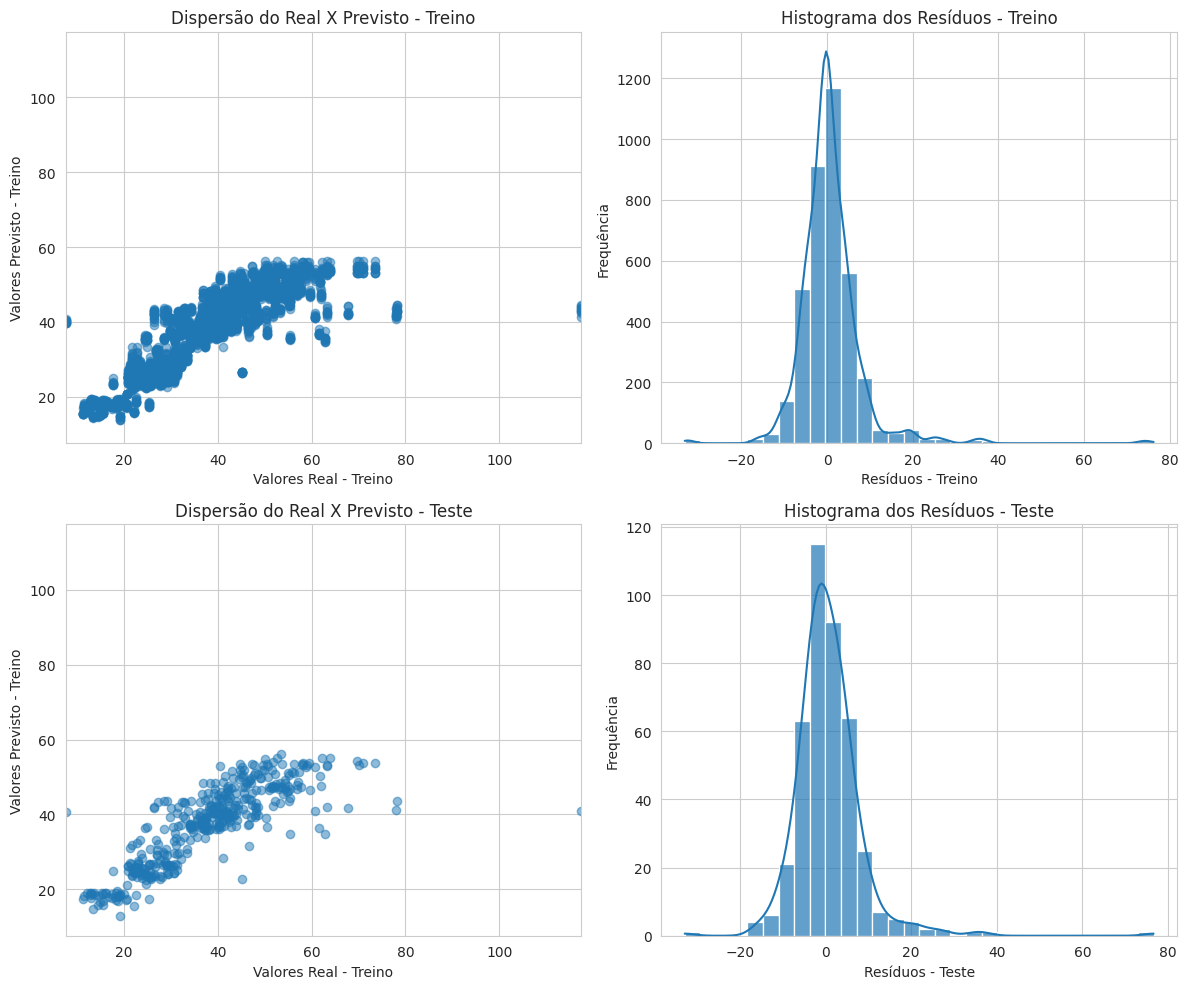


MELHOR GLOBAL (prioridade: Hit@10)
Modelo: SVR(rbf) | Escalonador: zscore
Hit@10=0.5274 | Hit@20=0.8133 | R²=0.6735 | RMSE=7.6062


In [7]:
best_global = df_global.iloc[0].to_dict()
best_global_obj = next(r for r in all_results
                       if r["summary"]["model"] == best_global["model"]
                       and r["summary"]["scaler"] == best_global["scaler"])

y_tr, y_tr_pred, y_te, y_te_pred = best_global_obj["y_all"]

titulo = f"Melhor global: {best_global['model']} | scaler={best_global['scaler']}"
aux.analisar_residuos(y_tr, y_tr_pred, y_te, y_te_pred, aux, titulo=titulo)

print("\n" + "=" * 90)
print("MELHOR GLOBAL (prioridade: Hit@10)")
print(f"Modelo: {best_global['model']} | Escalonador: {best_global['scaler']}")
print(f"Hit@10={best_global['Hit@10_mean']:.4f} | Hit@20={best_global['Hit@20_mean']:.4f} | "
      f"R²={best_global['R2_mean']:.4f} | RMSE={best_global['RMSE_mean']:.4f}")
